In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../'))

from collections import defaultdict
from evaluation.evaluation_harness import OnlineEvaluator, include_coldstart, include_no_interactions, include_some_interactions, include_all, score_time_spent, score_constant
from statistical_test import estimate_probability_each_model_is_best
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.path.abspath(''), '../backend'))
from backend.blueprints.recommendation import model_wrappers

%load_ext autoreload
%autoreload 2

In [2]:
evaluator = OnlineEvaluator(include_all, score_constant)

In [3]:
current_models = []
for model_wrapper in model_wrappers:
    model_wrapper.model = model_wrapper.definition()
    model_wrapper.model.load(model_wrapper.model_save_file_name, load_published_model=True)
    current_models.append((model_wrapper.model.name(), model_wrapper.model_save_file_name))
evaluation_names = {'evaluation_test_random_model': 'random_model', 'evaluation_test_popularity_model': 'popularity_model', 'evaluation_test_common_neighbors_constant_scoring': 'common_neighbors_constant_scoring', 'evaluation_test_common_neighbors': 'common_neighbors_gaussian_scoring', 'evaluation_test_common_neighbors_percentile_scoring': 'common_neighbors_percentile_scoring', 'evaluation_test_cf_low_weight_decay_increased_lr_best_model_bugfix': 'cf', 'evaluation_test_gcf_low_weight_decay_increased_lr_best_model_bugfix': 'non_linear_cf', 'evaluation_test_mlp_low_weight_decay_increased_lr_best_model_bugfix': 'mlp', 'evaluation_test_ncf_low_weight_decay_increased_lr_best_model_bugfix': 'neural_cf', 'evaluation_test_cf_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'cf_with_game_embeddings', 'evaluation_test_gcf_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'non_linear_cf_with_game_embeddings', 'evaluation_test_mlp_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'mlp_with_game_embeddings', 'evaluation_test_ncf_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'neural_cf_with_game_embeddings'}

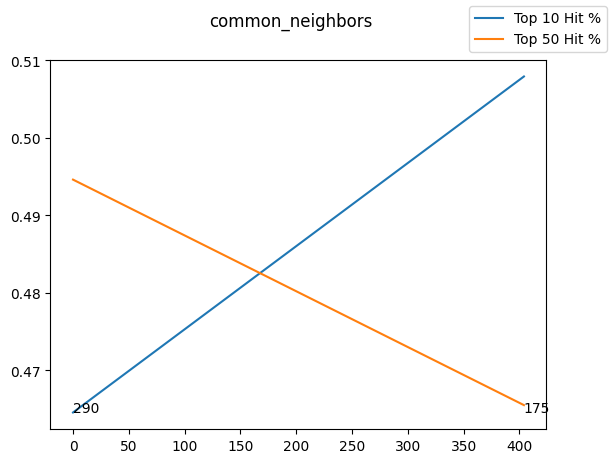

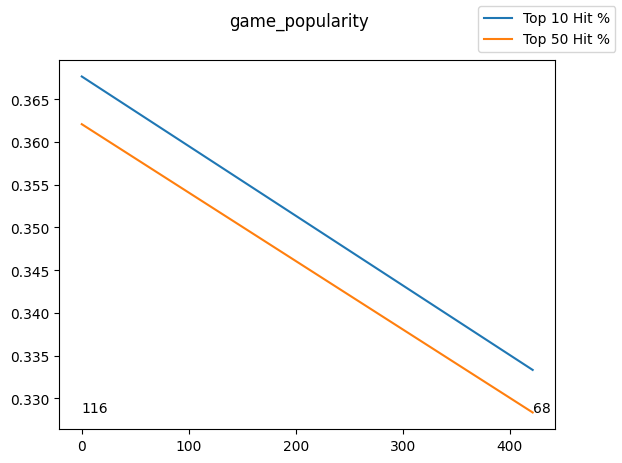

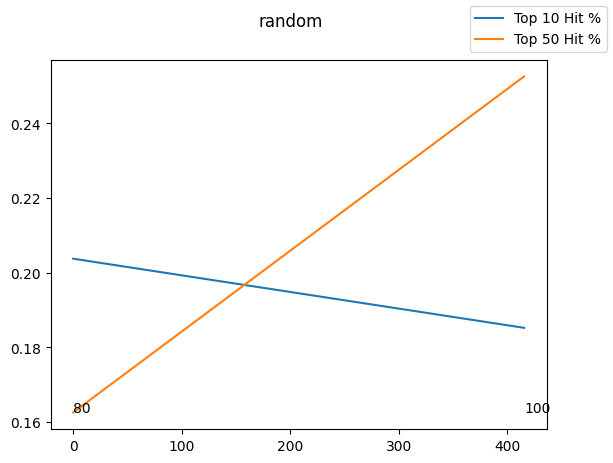

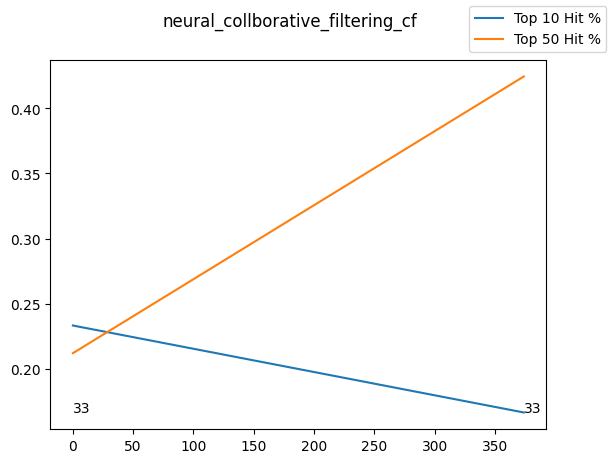

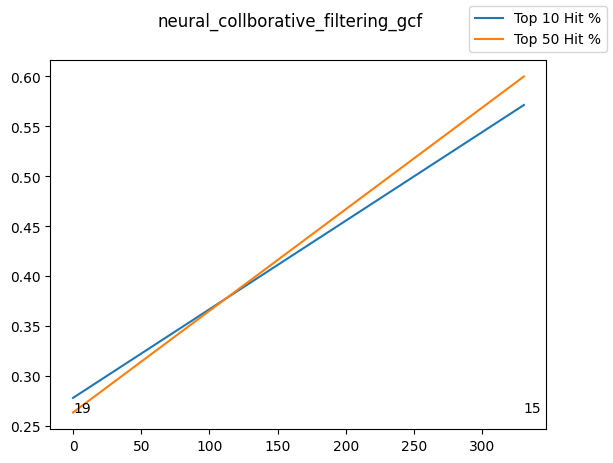

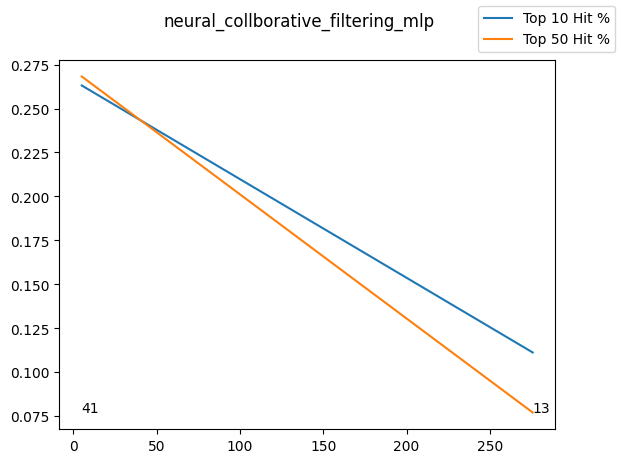

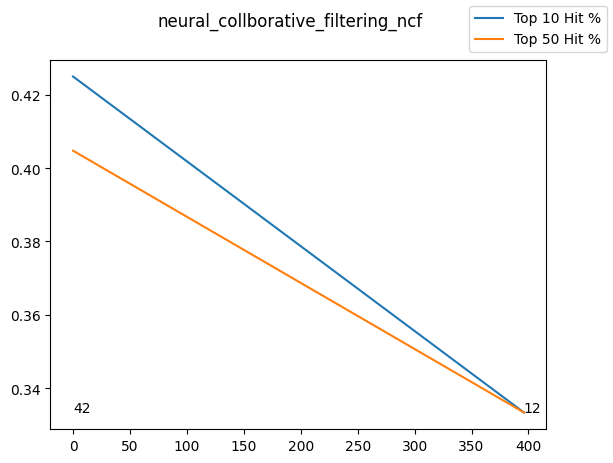

In [4]:
bucket_width = 5

cur_models_by_name = defaultdict(list)
for model_name, model_save_path in current_models:
    if model_save_path not in evaluation_names:
        continue
    cur_models_by_name[model_name].append(model_save_path)
for model_name, model_save_paths in cur_models_by_name.items():
    evaluator.reset(model_name, model_save_paths)
    num_interactions = evaluator.results_df["num_game_interactions_external"] + evaluator.results_df["num_game_interactions_local"]
    min_num = num_interactions.min()
    max_num = num_interactions.max()

    xs = []
    y_10s = []
    y_50s = []
    counts = []
    bucket_width = (max_num - min_num) / 3
    for start in [min_num, min_num + 2 * bucket_width]:
        evaluator.reset(model_name, model_save_paths, start, start + bucket_width)
        if evaluator.metrics["num_interactions"] == 0:
            continue
        evaluator.compute_top_N_hit_percentage(10)
        evaluator.compute_top_N_hit_percentage(50)
        xs.append(start)
        y_10s.append(evaluator.metrics["top_10_hit_percentage"])
        y_50s.append(evaluator.metrics["top_50_hit_percentage"])
        counts.append(evaluator.metrics["num_interactions"])
    fig = plt.figure()
    fig.suptitle(model_name)
    ax = fig.add_subplot()
    ax.plot(xs, y_10s, label="Top 10 Hit %")
    ax.plot(xs, y_50s, label="Top 50 Hit %")
    min_val = min(y_10s + y_50s)
    for x, count in zip(xs, counts):
        ax.annotate(count, (x, min_val))
    fig.legend()

In [5]:
# groups = evaluator.all_results.groupby(by=["rec_model_name", "rec_model_save_path"])
# for (model_name, model_save_path), data in groups:
all_metrics = []
for model_name, model_save_path in current_models:
    evaluator.reset(model_name, model_save_path)
    # evaluator.plot_top_N_hit_percentage_percentiles(10)
    evaluator.compute_top_N_hit_percentage(10)
    # evaluator.plot_top_N_hit_percentage_percentiles(50)
    evaluator.compute_top_N_hit_percentage(50)
    # evaluator.plot_user_rank_roc_curve()
    evaluator.compute_user_rank_auc_roc()
    # evaluator.save_metrics('test_online_evaluator', overwrite=True)
    # pprint(evaluator.metrics)
    all_metrics.append({'model_name': model_name, 'model_save_path': model_save_path, **evaluator.metrics})
    # print()
results = pd.DataFrame(all_metrics)
estimate_probability_each_model_is_best(results, 'user_rank_auc_roc')
estimate_probability_each_model_is_best(results, 'top_10_hit_percentage')
estimate_probability_each_model_is_best(results, 'top_50_hit_percentage')

In [6]:
df = results.loc[results['model_save_path'].isin(evaluation_names), ['model_save_path', 'num_interactions', 'user_rank_auc_roc_best_probability', 'user_rank_auc_roc', 'user_rank_auc_roc_variance', 'top_50_hit_percentage_best_probability', 'top_50_hit_percentage', 'top_50_hit_percentage_variance', 'top_10_hit_percentage_best_probability', 'top_10_hit_percentage', 'top_10_hit_percentage_variance']].copy()
df['model_save_path'] = df['model_save_path'].map(evaluation_names)
display(df.sort_values(by='user_rank_auc_roc_best_probability', ascending=False))

,model_save_path,num_interactions,user_rank_auc_roc_best_probability,user_rank_auc_roc,user_rank_auc_roc_variance,top_50_hit_percentage_best_probability,top_50_hit_percentage,top_50_hit_percentage_variance,top_10_hit_percentage_best_probability,top_10_hit_percentage,top_10_hit_percentage_variance
12,neural_cf_with_game_embeddings,25,0.41828,0.657051,0.012706,0.21498,0.520000,0.044921,0.22317,0.541667,0.042357
10,non_linear_cf_with_game_embeddings,35,0.29799,0.630435,0.011376,0.00237,0.342857,0.008969,0.01939,0.370370,0.019943
8,neural_cf,58,0.07864,0.567568,0.006396,0.03024,0.362069,0.026727,0.04476,0.377778,0.033333
9,cf_with_game_embeddings,30,0.06956,0.527778,0.011794,0.20719,0.400000,0.131034,0.26104,0.444444,0.162393
7,mlp,32,0.06659,0.519481,0.012884,0.00023,0.343750,0.003935,0.02844,0.400000,0.019753
4,random_model,323,0.02699,0.575851,0.001409,0.00333,0.219101,0.025411,0.02496,0.269841,0.046083
1,common_neighbors_percentile_scoring,211,0.02612,0.573492,0.001588,0.25942,0.566667,0.031540,0.10116,0.482143,0.026342
6,non_linear_cf,29,0.00798,0.393939,0.014251,0.00956,0.379310,0.011501,0.00450,0.333333,0.013072
2,common_neighbors_gaussian_scoring,226,0.00368,0.532520,0.001522,0.19518,0.572414,0.011973,0.13186,0.533333,0.017172
11,mlp_with_game_embeddings,33,0.00354,0.271605,0.023811,0.00000,0.181818,0.003001,0.00000,0.111111,0.000000


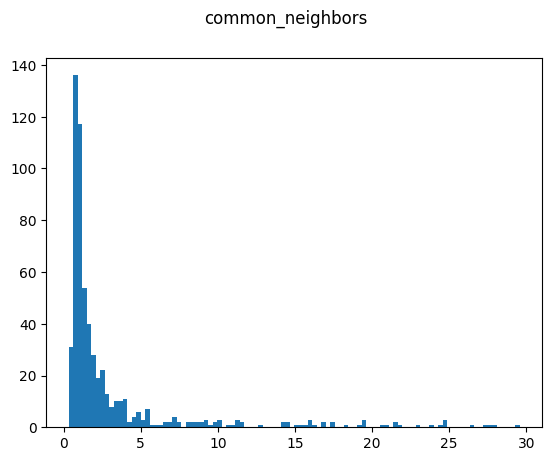

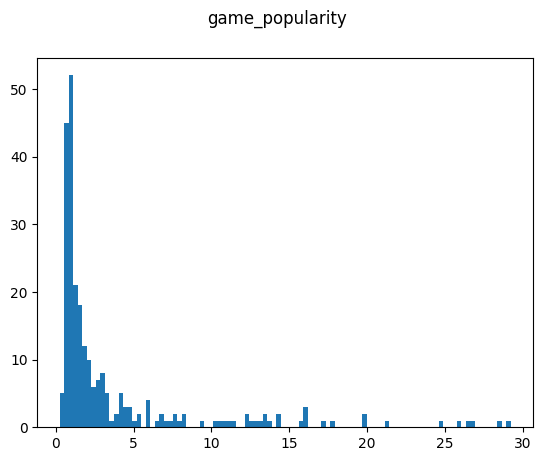

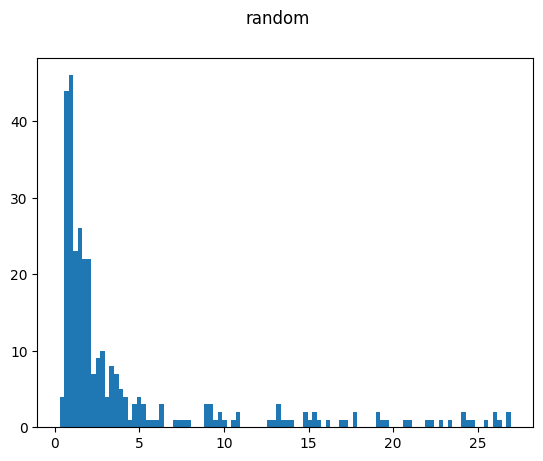

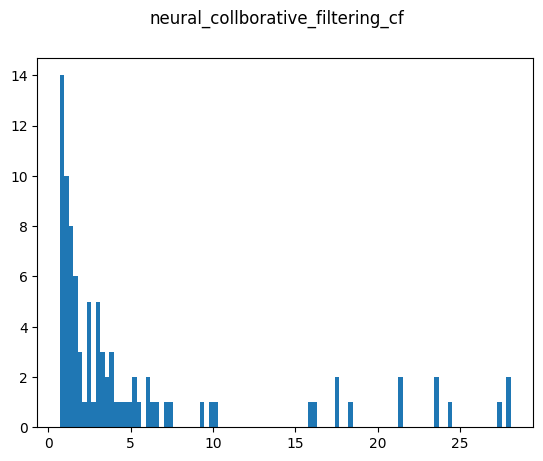

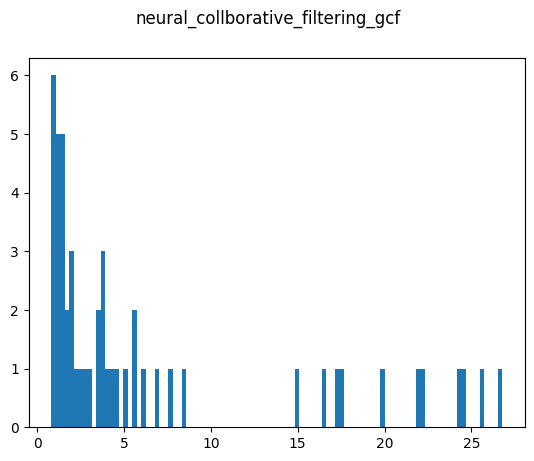

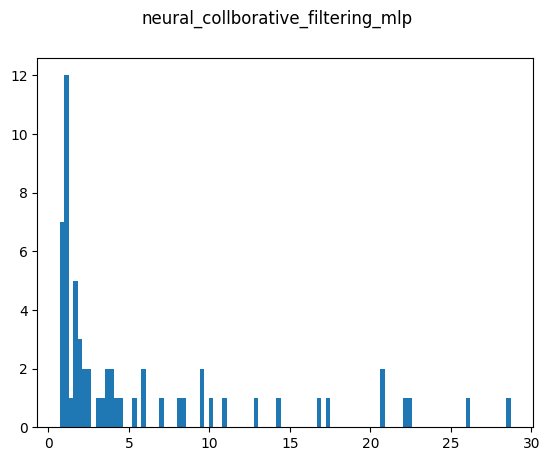

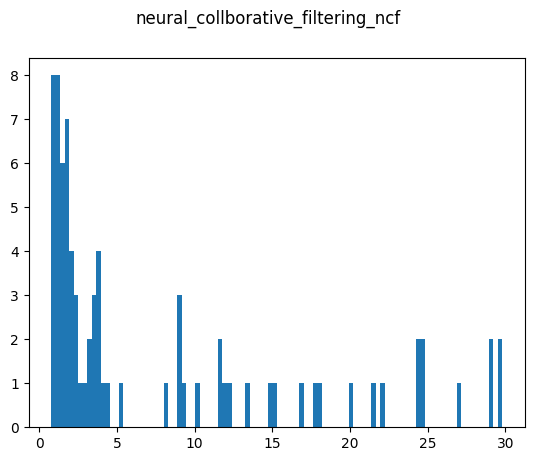

In [7]:

for model_name, model_save_paths in cur_models_by_name.items():
    evaluator.reset(model_name, model_save_paths)
    num_interactions = evaluator.results_df["num_game_interactions_external"] + evaluator.results_df["num_game_interactions_local"]
    min_num = num_interactions.min()
    max_num = num_interactions.max()

    xs = []
    y_10s = []
    y_50s = []
    bucket_width = (max_num - min_num) / 3
    evaluator.reset(model_name, model_save_paths)
    data = evaluator.results_df["time_spent"]
    data = data[data < 30]

    fig = plt.figure()
    fig.suptitle(model_name)
    ax = fig.add_subplot()
    ax.hist(data, bins=100)